## Introduction to Inpainting

With inpainting, you provide an image to be edited as well as a "mask" which defines which part of the image should be changed. The mask may either be provided as a black and white image (`maskImage`) or as a natural language description of what to change (`maskPrompt`). Inpainting can be used to remove items, replace items, or add new items to the original image.

### Use Case

OctankFashion has decided to refresh their product line for the summer by creating beach themed shirts for men. They want to use the current white collared shirt with a dog on it as a starting point and just replace the dog with a palm tree.

Let's use inpainting to help OctankFashion update their summer product line to reflect this change.


<div class="alert alert-block alert-warning">
<b>Prerequisites:</b> Please run the prerequiresites <b>00-prerequisites.ipynb</b> first before proceeding.
</div>


In [1]:
import io
import json
import base64
import boto3
from botocore.config import Config
from PIL import Image
from utils import save_image, plot_images

bedrock_runtime_client = boto3.client(
    "bedrock-runtime",
    region_name="us-east-1",
    config=Config(
        read_timeout=5 * 60
    ),  # IMPORTANT: Increase the read timeout to 5 minutes to support longer operations.
)
image_generation_model_id = "amazon.nova-canvas-v1:0"
output_dir = "output"

The following parameters are relevant to the "INPAINTING" task type and are encapsulated in the `inPaintingParams` field of the request body.

- `text` (Optional) – A text prompt to define what to change inside the mask. If you don't include this field, the model will remove the masked are from the image, replacing it with the background. Must be <= 1024 characters.
- `negativeText` (Optional) – A text prompt describing what elements or characteristics that should not be generated. Must be <= 1024 characters.
- The `inPaintingParams` fields are described below.
  - `image` (Required) – The JPEG or PNG image to modify, encoded as a Base64 string. (See code below for how to encode an image as Base64.)
  - You must define one of the following fields (but not both):
    - `maskPrompt` – A natural language text prompt that describing the region(s) of the image to edit.
    - `maskImage` – A black and white image in which pure black pixels indicate the area inside the mask and pure white pixels indicate the area outside the mask. The mask image must be the same dimensions at the input image. Its dimensions must match the dimensions of the input `image`.

The input image and mask image can be of any resolution that meets these requirements:

- Each side's length is no shorter than 320 and no longer than 4096
- Each side's length is evenly divisible by 16
- The aspect ratio ranges from 1:4 (portrait) through 4:1 (landscape)
- The total number of pixels (width x height) does not exceed 4,194,304 (the equivalent of 2048 x 2048)
- The `image` and `maskImage` must have the same resolution


#### Example 1: Inpainting with a mask prompt


With a mask prompt, you don't have to create your own mask image. Instead, you simply describe the object you want to replace. The model will automatically segment the image and identify the object you describe.

For this example, we'll use the following input image and a mask prompt of "dog image". Run the cells below. The generated image will be saved to the "output" folder.

<img src="data/text-to-image_seed-1.png" height="400">


In [3]:
# Define the main input parameters.
reference_image_path = "data/text-to-image_seed-1.png"
mask_prompt = "dog image"

text = "a white tshirt with a palm tree graphic"
negative_text = (
    "colorful"  # We're using a negative prompt to encourage a monochromatic graphic
)

seed = 12

Generating image...
Image saved to output/02-inpainting-with-mask-prompt.png


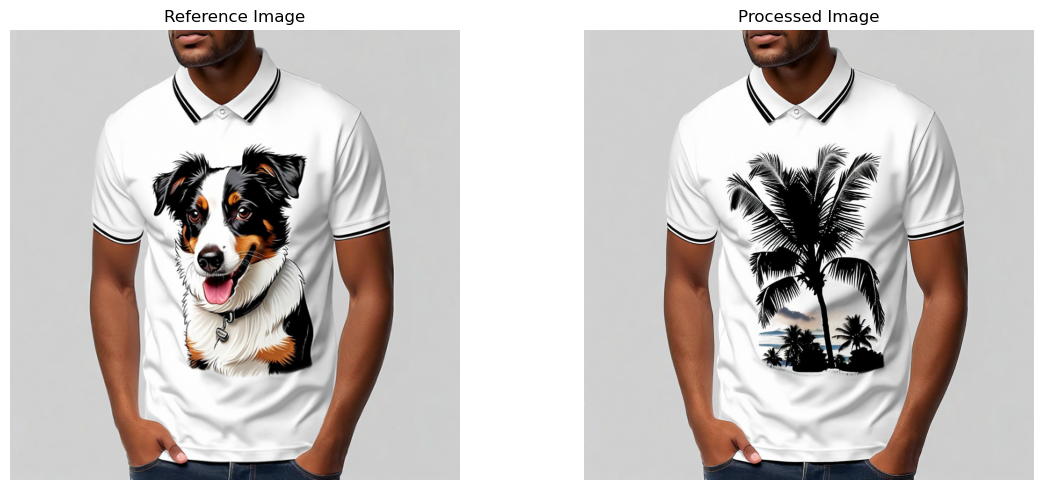

In [4]:
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "INPAINTING",
        "inPaintingParams": {
            "text": text,  # What to generate in the masked area
            "negativeText": negative_text,  # What to avoid generating inside the mask
            "image": reference_image_base64,  # The image to edit
            "maskPrompt": mask_prompt,  # A description of the area(s) of the image to change
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,  # Number of images to generate, up to 5.
            "cfgScale": 6.5,  # How closely the prompt will be followed
            "seed": seed,  # Any number from 0 through 858,993,459
            "quality": "standard",  # Either "standard" or "premium". Defaults to "standard".
        },
    }
)

print("Generating image...")

response = bedrock_runtime_client.invoke_model(
    body=body,
    modelId=image_generation_model_id,
    accept="application/json",
    contentType="application/json",
)

response_body = json.loads(response.get("body").read())

base64_images = response_body.get("images")
image_path = f"{output_dir}/02-inpainting-with-mask-prompt.png"
save_image(base64_images[0], image_path)

print(f"Image saved to {image_path}")

response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in base64_images
]

plot_images(response_images, ref_image_path=reference_image_path)

#### Example 2: Inpainting with a mask image


Alternatively, you can provide the mask image to directly control the region the model should reconstruct. Here's an example of a mask image corresponding to the printable area of the shirt.

<img src="data/text-to-image_seed-1.png" height="400" style="margin: 4px"> <img src="data/text-to-image_seed-1_mask.png" height="400" style="margin: 4px; border: 1px solid #99999955">

We will now use this mask image to reconstruct our image. Run the cells below. The generated image will be saved to the "output" folder.


In [5]:
# Define the main input parameters.
reference_image_path = "data/text-to-image_seed-1.png"
mask_image_path = "data/text-to-image_seed-1_mask.png"

text = "a white tshirt with a palm tree graphic"
negative_text = "colorful"

seed = 100

Generating image...
Image saved to output/02-inpainting-with-mask-image.png


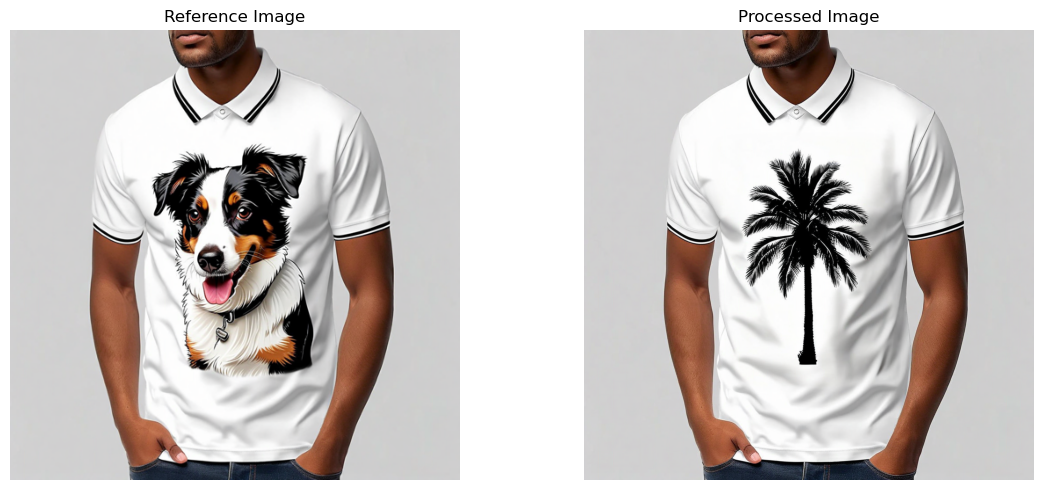

In [6]:
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

with open(mask_image_path, "rb") as image_file:
    image_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "INPAINTING",
        "inPaintingParams": {
            "text": text,  # What to generate in the masked area
            "negativeText": negative_text,  # What to avoid generating inside the mask
            "image": reference_image_base64,  # The image to edit
            "maskImage": image_image_base64,  # A black and white image defining the mask
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,  # Number of images to generate, up to 5
            "cfgScale": 6.5,  # How closely the prompt will be followed
            "seed": seed,  # Any number from 0 through 858,993,459
            "quality": "standard",  # Either "standard" or "premium". Defaults to "standard".
        },
    }
)

print("Generating image...")

response = bedrock_runtime_client.invoke_model(
    body=body,
    modelId=image_generation_model_id,
    accept="application/json",
    contentType="application/json",
)

response_body = json.loads(response.get("body").read())

base64_images = response_body.get("images")
image_path = f"{output_dir}/02-inpainting-with-mask-image.png"
save_image(base64_images[0], image_path)

print(f"Image saved to {image_path}")

response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

plot_images(response_images, ref_image_path=reference_image_path)

<div class="alert alert-block alert-info">
<strong>💡 Bonus Activity:</strong> Try a different seed to generate different variations. Try a different prompt to make more drastic changes.
</div>


## Take Away

Inpainting is a powerful technique that allows users to manipulate and restore images with remarkable precision. By utilizing either mask images or mask prompts, individuals can seamlessly remove unwanted objects, fill in missing areas, or even add new elements to existing images. This versatile tool has numerous applications, from photo restoration and digital art creation to removing distractions in professional photography. Whether you're touching up old family photos, creating imaginative digital compositions, or enhancing product images for e-commerce, inpainting offers a user-friendly solution for achieving polished, professional-looking results.
